# Airbnb Price Prediction

## 3. Feature Engineering

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.impute import KNNImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from skopt import BayesSearchCV
from sklearn.linear_model import LassoCV

import requests
import time
from datetime import datetime

import category_encoders as ce
import itertools

import warnings
warnings.filterwarnings('ignore')

In [2]:
# load dataset
df = pd.read_csv("data/df_cleaned.csv", index_col=0)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74109 entries, 0 to 74110
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   log_price               74109 non-null  float64
 1   property_type           74109 non-null  object 
 2   room_type               74109 non-null  object 
 3   amenities               74109 non-null  object 
 4   accommodates            74109 non-null  int64  
 5   bathrooms               74109 non-null  float64
 6   cancellation_policy     74109 non-null  object 
 7   cleaning_fee            74109 non-null  bool   
 8   city                    74109 non-null  object 
 9   description             74109 non-null  object 
 10  host_identity_verified  74109 non-null  object 
 11  host_response_rate      74109 non-null  float64
 12  host_since              74109 non-null  object 
 13  instant_bookable        74109 non-null  object 
 14  latitude                74109 non-null

# 3.1 New Feature Generation

### 3.1.1 Distance from Downtown

In [4]:
# downtown coordinates
city_coordinates = {
    'Boston': {'latitude': 42.3601, 'longitude': -71.0589},
    'Chicago': {'latitude': 41.8781, 'longitude': -87.6298},
    'DC': {'latitude': 38.89511, 'longitude': -77.03637},
    'LA': {'latitude': 34.0522, 'longitude': -118.2437},
    'NYC': {'latitude': 40.7128, 'longitude': -74.0060},
    'SF': {'latitude': 37.7749, 'longitude': -122.4194}
}

# downtown coordinates by city
df['downtown_latitude'] = df['city'].map(lambda x: city_coordinates.get(x, {}).get('latitude'))
df['downtown_longitude'] = df['city'].map(lambda x: city_coordinates.get(x, {}).get('longitude'))

df.head()

,log_price,property_type,room_type,amenities,accommodates,bathrooms,cancellation_policy,cleaning_fee,city,description,...,longitude,neighbourhood,number_of_reviews,review_scores_rating,zipcode,bedrooms,beds,is_new_listing,downtown_latitude,downtown_longitude
0,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,strict,True,NYC,"Beautiful, sunlit brownstone 1-bedroom in the ...",...,-73.991617,Brooklyn Heights,2,100.0,11201,1.0,1.0,0,40.71280,-74.00600
1,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,strict,True,NYC,Enjoy travelling during your stay in Manhattan...,...,-73.989040,Hell's Kitchen,6,93.0,10019,3.0,3.0,0,40.71280,-74.00600
2,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,moderate,True,NYC,The Oasis comes complete with a full backyard ...,...,-73.943756,Harlem,10,92.0,10027,1.0,3.0,0,40.71280,-74.00600
3,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,flexible,True,SF,This light-filled home-away-from-home is super...,...,-122.431619,Lower Haight,0,96.0,94117,2.0,2.0,1,37.77490,-122.41940
4,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,moderate,True,DC,"Cool, cozy, and comfortable studio located in ...",...,-77.034596,Columbia Heights,4,40.0,20009,0.0,1.0,0,38.89511,-77.03637


In [5]:
# Function for Haversine distance
def haversine(lat1, lon1, lat2, lon2):
    # radian transformation
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    # Haversine equation
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    R = 6371  # earth radian in km
    return R * c

df['latitude'] = df['latitude'].astype(float)
df['longitude'] = df['longitude'].astype(float)
df['downtown_latitude'] = df['downtown_latitude'].astype(float)
df['downtown_longitude'] = df['downtown_longitude'].astype(float)

df['distance_to_downtown'] = haversine(df['latitude'], df['longitude'], df['downtown_latitude'], df['downtown_longitude'])
df[['distance_to_downtown']].head()

,distance_to_downtown
0,2.178424
1,6.098174
2,11.823735
3,1.121160
4,3.396798


In [6]:
df.drop(columns=['longitude', 'latitude', 'downtown_latitude', 'downtown_longitude'], inplace=True)

### 3.1.2 Hosting Duration

In [7]:
df['host_since'] = pd.to_datetime(df['host_since'], errors='coerce')
today = datetime.now()
df['hosting_duration_years'] = (today - df['host_since']).dt.days / 365

In [8]:
df.drop(columns=['host_since'], inplace=True)

### 3.1.3 New Features from 'description' column: Features Generation From Text 

In [9]:
df[['description']]

,description
0,"Beautiful, sunlit brownstone 1-bedroom in the ..."
1,Enjoy travelling during your stay in Manhattan...
2,The Oasis comes complete with a full backyard ...
3,This light-filled home-away-from-home is super...
4,"Cool, cozy, and comfortable studio located in ..."
...,...
74106,one room in bushwick apt
74107,"Located on the Pacific Coast Highway, this apa..."
74108,A modern apartment located in East Williamsbur...
74109,"Fully renovated, designer's studio located in ..."


In [10]:
# text length
df['description_length'] = df['description'].apply(len)
df['word_count'] = df['description'].apply(lambda x: len(x.split()))

In [11]:
# 1. Define the TF-IDF Vectorizer and extract the top 300 important words
tfidf_vectorizer = TfidfVectorizer(max_features=300, stop_words='english')
tfidf_vectorizer.fit(df['description'])
important_words = set(tfidf_vectorizer.get_feature_names_out())

# 2. Define a function to calculate the ratio of important words in each description
def calculate_word_ratio(text, important_words):
    words = text.split()  # Split the text into individual words
    total_words = len(words)  # Count the total number of words
    important_count = sum(1 for word in words if word in important_words)  # Count words from the top 300
    return important_count / total_words if total_words > 0 else 0  # Calculate the ratio

# 3. Apply the function to each description and add the ratio as a new feature
df['important_word_ratio'] = df['description'].apply(lambda x: calculate_word_ratio(x, important_words))

# Display the results
print(df[['description', 'important_word_ratio']].head())

                                         description  important_word_ratio
0  Beautiful, sunlit brownstone 1-bedroom in the ...              0.129032
1  Enjoy travelling during your stay in Manhattan...              0.190476
2  The Oasis comes complete with a full backyard ...              0.179641
3  This light-filled home-away-from-home is super...              0.307692
4  Cool, cozy, and comfortable studio located in ...              0.147826


In [12]:
# Define the list of selected important words related to location and property condition
selected_important_words = {
    'access', 'amenities', 'appliances', 'area', 'areas', 'attractions', 
    'avenue', 'backyard', 'balcony', 'beach', 'big', 'bike', 'boston', 
    'brooklyn', 'center', 'central', 'centrally', 'city', 'close',
    'dc', 'distance', 'district', 'downtown', 'entire', 'families', 'family',
    'francisco', 'friendly', 'furnished', 'furniture', 'garden',
    'hardwood', 'hill', 'hills', 'historic', 'hollywood', 'located', 
    'location', 'luxury', 'main', 'major', 'manhattan', 'market', 'metro',
    'modern', 'monica', 'museum', 'near', 'nearby', 'neighborhood', 
    'neighborhoods', 'new', 'newly', 'nyc', 'park', 'parking', 'patio',
    'plenty', 'pool', 'privacy', 'private', 'renovated', 'restaurants', 
    'safe', 'san', 'santa', 'shopping', 'shops', 'store', 'stores', 
    'street', 'suite', 'union', 'venice', 'view', 'views', 'walk', 
    'walking', 'williamsburg', 'yard', 'york'
}

# Function to calculate the count and ratio of selected words in a description
def calculate_selected_word_features(text, selected_words):
    words = text.split()  # Split the text into words
    total_words = len(words)  # Calculate the total word count
    selected_count = sum(1 for word in words if word in selected_words)  # Count the selected important words
    ratio = selected_count / total_words if total_words > 0 else 0  # Calculate the ratio of selected words
    return selected_count, ratio

# Apply the function to the description column and create two new features
df['selected_word_count'], df['selected_word_ratio'] = zip(
    *df['description'].apply(lambda x: calculate_selected_word_features(x, selected_important_words))
)

# Display the resulting features
print(df[['description', 'selected_word_count', 'selected_word_ratio']].head())

                                         description  selected_word_count  \
0  Beautiful, sunlit brownstone 1-bedroom in the ...                    3   
1  Enjoy travelling during your stay in Manhattan...                   14   
2  The Oasis comes complete with a full backyard ...                   11   
3  This light-filled home-away-from-home is super...                    7   
4  Cool, cozy, and comfortable studio located in ...                    6   

   selected_word_ratio  
0             0.096774  
1             0.083333  
2             0.065868  
3             0.089744  
4             0.052174  


### 3.1.4  New Features from 'amenities' column: Features Generation From Strings 

In [13]:
df['amenities']

0        {"Wireless Internet","Air conditioning",Kitche...
1        {"Wireless Internet","Air conditioning",Kitche...
2        {TV,"Cable TV","Wireless Internet","Air condit...
3        {TV,"Cable TV",Internet,"Wireless Internet",Ki...
4        {TV,Internet,"Wireless Internet","Air conditio...
                               ...                        
74106                                                   {}
74107    {TV,"Cable TV",Internet,"Wireless Internet",Ki...
74108    {TV,Internet,"Wireless Internet","Air conditio...
74109    {TV,"Wireless Internet","Air conditioning",Kit...
74110    {TV,Internet,"Wireless Internet",Kitchen,"Free...
Name: amenities, Length: 74109, dtype: object

In [14]:
# Data Cleaning and Transformation

# Function to convert string to a list and remove unnecessary amenities
def preprocess_amenities(amenities_str):
    # Remove {} and " characters, then split by comma
    amenities_list = re.sub(r"[{}\"]", "", amenities_str).split(',')
    # Remove unnecessary items (e.g., "translation missing"), strip whitespace, and standardize to lowercase
    cleaned_amenities = [amenity.strip().lower() for amenity in amenities_list 
                         if not amenity.startswith("translation missing")]
    return cleaned_amenities

# Apply the cleaning function to the 'amenities' column
df['amenities'] = df['amenities'].apply(preprocess_amenities)

# Display the cleaned amenities list
print(df['amenities'].head())

0    [wireless internet, air conditioning, kitchen,...
1    [wireless internet, air conditioning, kitchen,...
2    [tv, cable tv, wireless internet, air conditio...
3    [tv, cable tv, internet, wireless internet, ki...
4    [tv, internet, wireless internet, air conditio...
Name: amenities, dtype: object


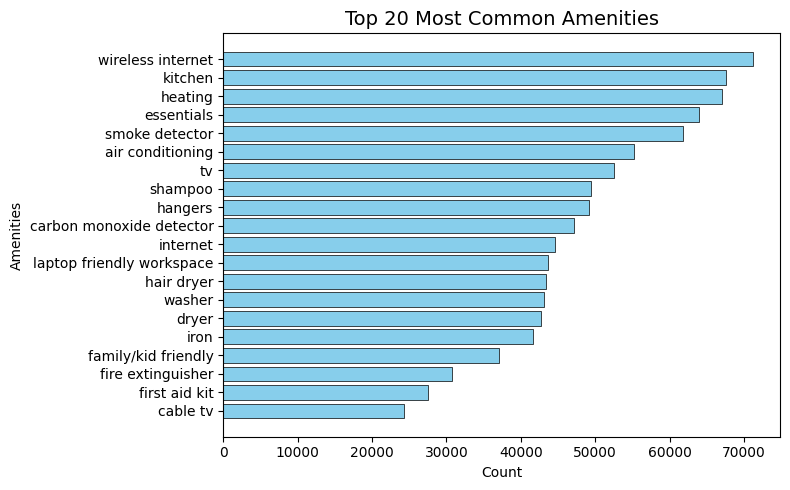

In [15]:
# Distribution of amenities

from collections import Counter

# Count occurrences of all amenities
all_amenities = [amenity for amenities in df['amenities'] for amenity in amenities]
amenities_counts = Counter(all_amenities)

# Extract the top 20 amenities and their counts
amenities, counts = zip(*amenities_counts.most_common(20))

plt.figure(figsize=(8, 5))
plt.barh(amenities, counts, color='skyblue', edgecolor='black', linewidth=.5)

# Add labels and title
plt.xlabel('Count', fontsize=10)
plt.ylabel('Amenities', fontsize=10)
plt.title('Top 20 Most Common Amenities', fontsize=14)
plt.gca().invert_yaxis() 

# Improve layout
plt.tight_layout()

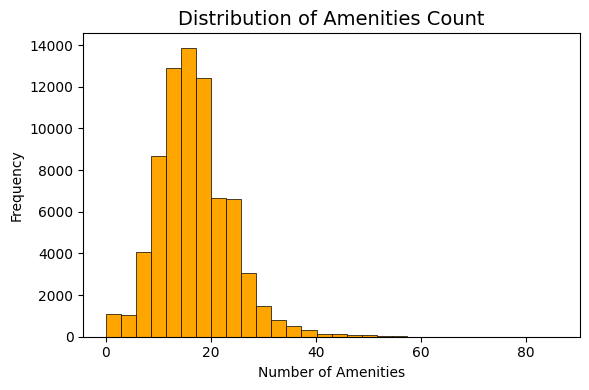

In [16]:
# Number of Amenities per Listing
df['amenities_count'] = df['amenities'].apply(len)

plt.figure(figsize=(6, 4))
plt.hist(df['amenities_count'], bins=30, color='orange', edgecolor='black', linewidth=0.5)

plt.xlabel('Number of Amenities', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.title('Distribution of Amenities Count', fontsize=14)

# Show the plot
plt.tight_layout()

Text(0, 0.5, 'WCSS')

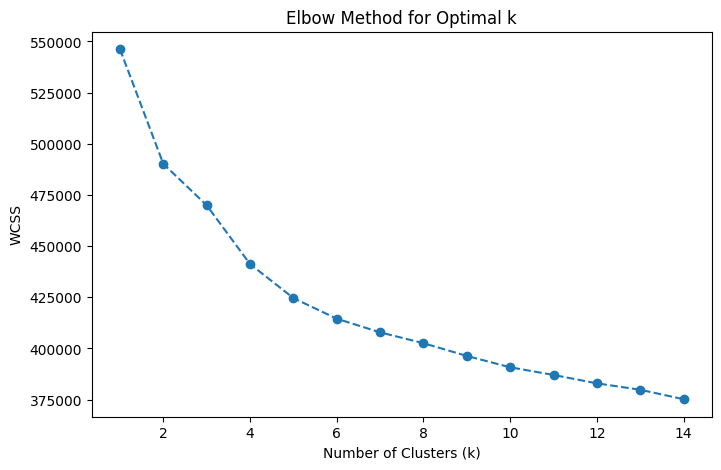

In [17]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.cluster import KMeans

# One-hot encode the amenities list
mlb = MultiLabelBinarizer()
amenities_encoded = mlb.fit_transform(df['amenities'])
amenities_df = pd.DataFrame(amenities_encoded, columns=mlb.classes_)

# Calculate WCSS for different values of k
wcss = []
for k in range(1, 15):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(amenities_encoded)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, 15), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')


In [18]:
# Apply K-means clustering
kmeans = KMeans(n_clusters=5, random_state=42)
df['amenities_cluster'] = kmeans.fit_predict(amenities_encoded)

In [19]:
df.drop(columns=['amenities', 'description'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74109 entries, 0 to 74110
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   log_price               74109 non-null  float64
 1   property_type           74109 non-null  object 
 2   room_type               74109 non-null  object 
 3   accommodates            74109 non-null  int64  
 4   bathrooms               74109 non-null  float64
 5   cancellation_policy     74109 non-null  object 
 6   cleaning_fee            74109 non-null  bool   
 7   city                    74109 non-null  object 
 8   host_identity_verified  74109 non-null  object 
 9   host_response_rate      74109 non-null  float64
 10  instant_bookable        74109 non-null  object 
 11  neighbourhood           74109 non-null  object 
 12  number_of_reviews       74109 non-null  int64  
 13  review_scores_rating    74109 non-null  float64
 14  zipcode                 74109 non-null

* 9 New Features: distance_to_downtown, hosting_duration_years, description_length,  word_count, important_word_ratio, selected_word_count, selected_word_ratio, amenities_count, amenities_cluster

## 3.2 Binary Encoding

In [20]:
df[['zipcode', 'neighbourhood']].nunique()

zipcode          669
neighbourhood    619
dtype: int64

* The levels of zipcode and neighbourhood are quite high, with 669 and 619 unique values, respectively. Due to this, one-hot encoding is not suitable as it can lead to issues such as high dimensionality and overfitting. In such cases, alternative encoding methods can be used, such as target encoding or binary encoding. Among these, binary encoding is chosen for its advantages, including reducing dimensionality while retaining interpretability.

In [21]:
# Instantiate the BinaryEncoder
encoder = ce.BinaryEncoder(cols=['zipcode', 'neighbourhood'])
df_encoded = encoder.fit_transform(df)

## 3.3 One-hot Encoding

In [22]:
categorical_columns = ['property_type', 'room_type', 'cancellation_policy', 'cleaning_fee',
                       'city', 'host_identity_verified', 'instant_bookable', 'amenities_cluster']

df_encoded = pd.get_dummies(df_encoded, columns=categorical_columns, drop_first=True)

In [23]:
len(df_encoded.columns)

58

# 4. Modeling and Performance Evaluation

In [24]:
X = df_encoded.drop(columns=['log_price'])
y = df_encoded['log_price']

# Split the data into training and test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features for models like MLP and XGBoost that are sensitive to feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [25]:
# Function to evaluate model performance
def evaluate_model(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    metrics = {
        "Train MAE": mean_absolute_error(y_train, y_train_pred),
        "Train RMSE": np.sqrt(mean_squared_error(y_train, y_train_pred)),
        "Train R^2": r2_score(y_train, y_train_pred),
        "Test MAE": mean_absolute_error(y_test, y_test_pred),
        "Test RMSE": np.sqrt(mean_squared_error(y_test, y_test_pred)),
        "Test R^2": r2_score(y_test, y_test_pred),
    }
    return metrics, y_test_pred

In [26]:
# 1. Lasso Regression
print("Tuning Lasso Regression...")

# Define the Lasso model
lasso_model = Lasso()

# Define the hyperparameter grid (alpha: regularization strength)
param_grid = {"alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10]}

# GridSearchCV to find the best alpha value
grid_search = GridSearchCV(lasso_model, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, y_train)

# Best model and parameters
best_lasso_model = grid_search.best_estimator_
best_alpha = grid_search.best_params_['alpha']

print(f"Best alpha for Lasso Regression: {best_alpha}")

# Evaluate the model
lasso_metrics, lasso_preds = evaluate_model(best_lasso_model, X_train_scaled, X_test_scaled, y_train, y_test)
lasso_results = {"Model": "Lasso Regression", "Best Parameters": f"alpha={best_alpha}", **lasso_metrics}
print("Lasso Regression Results:", lasso_results)

Tuning Lasso Regression...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best alpha for Lasso Regression: 0.0001
Lasso Regression Results: {'Model': 'Lasso Regression', 'Best Parameters': 'alpha=0.0001', 'Train MAE': 0.3474475953477809, 'Train RMSE': 0.46250223646276184, 'Train R^2': 0.5853949096534095, 'Test MAE': 0.34073447387282696, 'Test RMSE': 0.4530150351126405, 'Test R^2': 0.5954889771101808}


In [27]:
# 2. Random Forest
print("Tuning Random Forest...")
rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_param_grid = {
    "n_estimators": [200, 250, 300],
    "max_depth": [15, 20, 25],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [4, 6, 8],
}
rf_grid_search = GridSearchCV(rf_model, rf_param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=-1, verbose=1)
rf_grid_search.fit(X_train_scaled, y_train)

best_rf_model = rf_grid_search.best_estimator_
rf_metrics, rf_preds = evaluate_model(best_rf_model, X_train_scaled, X_test_scaled, y_train, y_test)
rf_results = {"Model": "Random Forest", "Best Parameters": rf_grid_search.best_params_, **rf_metrics}
print("Random Forest Results:", rf_results)

Tuning Random Forest...
Fitting 3 folds for each of 81 candidates, totalling 243 fits
Random Forest Results: {'Model': 'Random Forest', 'Best Parameters': {'max_depth': 25, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 300}, 'Train MAE': 0.16638022692509494, 'Train RMSE': 0.24323750499042224, 'Train R^2': 0.8853251883303218, 'Test MAE': 0.28543974721691767, 'Test RMSE': 0.39291506370756446, 'Test R^2': 0.6956996253803287}


In [28]:
# 3. XGBoost
print("Tuning XGBoost...")
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_param_grid = {
    "n_estimators": [200, 250, 300],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [10, 15, 20],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.3, 0.5, 0.7],
}
xgb_grid_search = GridSearchCV(xgb_model, xgb_param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=-1, verbose=1)
xgb_grid_search.fit(X_train_scaled, y_train)

best_xgb_model = xgb_grid_search.best_estimator_
xgb_metrics, xgb_preds = evaluate_model(best_xgb_model, X_train_scaled, X_test_scaled, y_train, y_test)
xgb_results = {"Model": "XGBoost", "Best Parameters": xgb_grid_search.best_params_, **xgb_metrics}
print("XGBoost Results:", xgb_results)

Tuning XGBoost...
Fitting 3 folds for each of 243 candidates, totalling 729 fits
XGBoost Results: {'Model': 'XGBoost', 'Best Parameters': {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 300, 'subsample': 0.8}, 'Train MAE': 0.15440488396338223, 'Train RMSE': 0.2098608967894673, 'Train R^2': 0.914636934190925, 'Test MAE': 0.2707724188542991, 'Test RMSE': 0.3750326134495558, 'Test R^2': 0.7227681001539432}


In [29]:
# 4. GBM
print("Tuning Gradient Boosting...")
gbm_model = GradientBoostingRegressor(random_state=42)
gbm_param_grid = {
    "n_estimators": [200, 150, 300],
    "learning_rate": [0.1, 0.2, 0.3],
    "max_depth": [7, 10, 15],
    "subsample": [1.0, 1.2, 1.5],
    "min_samples_split": [10, 15, 20],
}
gbm_grid_search = GridSearchCV(
    gbm_model, gbm_param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=-1, verbose=1
)
gbm_grid_search.fit(X_train_scaled, y_train)

best_gbm_model = gbm_grid_search.best_estimator_
gbm_metrics, gbm_preds = evaluate_model(best_gbm_model, X_train_scaled, X_test_scaled, y_train, y_test)
gbm_results = {"Model": "Gradient Boosting", "Best Parameters": gbm_grid_search.best_params_, **gbm_metrics}
print("Gradient Boosting Results:", gbm_results)

Tuning Gradient Boosting...
Fitting 3 folds for each of 243 candidates, totalling 729 fits
Gradient Boosting Results: {'Model': 'Gradient Boosting', 'Best Parameters': {'learning_rate': 0.1, 'max_depth': 7, 'min_samples_split': 10, 'n_estimators': 300, 'subsample': 1.0}, 'Train MAE': 0.22247416985937954, 'Train RMSE': 0.29996113672545055, 'Train R^2': 0.8256038323732788, 'Test MAE': 0.2744528771685463, 'Test RMSE': 0.379256475016262, 'Test R^2': 0.7164882015747336}


In [30]:
# 5. MLP Regressor
print("Tuning MLP Regressor...")
mlp_model = MLPRegressor(random_state=42, max_iter=500, early_stopping=True)
mlp_param_grid = {
    "hidden_layer_sizes": [(50,), (100,), (50, 50)],
    "activation": ['relu', 'tanh'],
    "solver": ['adam', 'lbfgs'],
    "learning_rate_init": [0.001, 0.01],
}
mlp_grid_search = GridSearchCV(mlp_model, mlp_param_grid, scoring='neg_mean_squared_error', cv=3,  n_jobs=-1, verbose=1)
mlp_grid_search.fit(X_train_scaled, y_train)

best_mlp_model = mlp_grid_search.best_estimator_
mlp_metrics, mlp_preds = evaluate_model(best_mlp_model, X_train_scaled, X_test_scaled, y_train, y_test)
mlp_results = {"Model": "MLP Regressor", "Best Parameters": mlp_grid_search.best_params_, **mlp_metrics}
print("MLP Regressor Results:", mlp_results)

Tuning MLP Regressor...
Fitting 3 folds for each of 24 candidates, totalling 72 fits
MLP Regressor Results: {'Model': 'MLP Regressor', 'Best Parameters': {'activation': 'relu', 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.001, 'solver': 'lbfgs'}, 'Train MAE': 0.2780178630651482, 'Train RMSE': 0.37881993054297397, 'Train R^2': 0.7218541427859775, 'Test MAE': 0.28898593546867984, 'Test RMSE': 0.3941534088376927, 'Test R^2': 0.6937784839167432}


In [31]:
# Compare results
all_results = [lasso_results, rf_results, xgb_results, gbm_results, mlp_results]
performance_df = pd.DataFrame(all_results)
print(performance_df)

               Model                                    Best Parameters  \
0   Lasso Regression                                       alpha=0.0001   
1      Random Forest  {'max_depth': 25, 'min_samples_leaf': 4, 'min_...   
2            XGBoost  {'colsample_bytree': 0.7, 'learning_rate': 0.0...   
3  Gradient Boosting  {'learning_rate': 0.1, 'max_depth': 7, 'min_sa...   
4      MLP Regressor  {'activation': 'relu', 'hidden_layer_sizes': (...   

   Train MAE  Train RMSE  Train R^2  Test MAE  Test RMSE  Test R^2  
0   0.347448    0.462502   0.585395  0.340734   0.453015  0.595489  
1   0.166380    0.243238   0.885325  0.285440   0.392915  0.695700  
2   0.154405    0.209861   0.914637  0.270772   0.375033  0.722768  
3   0.222474    0.299961   0.825604  0.274453   0.379256  0.716488  
4   0.278018    0.378820   0.721854  0.288986   0.394153  0.693778  


# Adding Ensemble Model

In [32]:
from scipy.optimize import minimize

# Collect train set predictions
rf_train_preds = best_rf_model.predict(X_train_scaled)
xgb_train_preds = best_xgb_model.predict(X_train_scaled)
gbm_train_preds = best_gbm_model.predict(X_train_scaled)
mlp_train_preds = best_mlp_model.predict(X_train_scaled)

# 1. Define the loss function for the weighted ensemble
# fn to calculate weighted ensemble predictions and evaluates their performance
def weighted_ensemble_loss(weights, preds, y_true):
    weights = np.array(weights)
    ensemble_preds = np.dot(weights, preds)
    return mean_absolute_error(y_true, ensemble_preds)

# 2. Prepare the train set data for optimization
model_preds = [rf_train_preds, xgb_train_preds, gbm_train_preds, mlp_train_preds]
y_train_true = y_train

# Initial weights: equal distribution
initial_weights = np.ones(len(model_preds)) / len(model_preds)

# Set bounds: each weight must be between lower bound and upper bound
bounds = [(0.2, 0.5)] * len(model_preds)

# Add a constraint: the sum of all weights must equal 1
constraints = {"type": "eq", "fun": lambda w: np.sum(w) - 1}

# 3. Optimize weights to minimize the loss function
result = minimize(
    fun=weighted_ensemble_loss,
    x0=initial_weights,
    args=(model_preds, y_train_true),
    bounds=bounds,
    constraints=constraints,
    method='SLSQP'  # Sequential Least Squares Programming
)

# Optimized weights
optimized_weights = result.x
print("Optimized Weights:", optimized_weights)

# 4. Calculate ensemble predictions for the test set
test_preds = [rf_preds, xgb_preds, gbm_preds, mlp_preds]

# Weighted ensemble predictions for the test set
ensemble_test_preds = np.dot(optimized_weights, test_preds)

# 5. Evaluate the ensemble model performance on the test set
ensemble_mae = mean_absolute_error(y_test, ensemble_test_preds)
ensemble_rmse = np.sqrt(mean_squared_error(y_test, ensemble_test_preds))
ensemble_r2 = r2_score(y_test, ensemble_test_preds)

# 6. Save ensemble results
ensemble_results = {
    "Model": "Ensemble",
    "Best Parameters": f"Optimized Weights: {optimized_weights}",
    "Train MAE": np.nan,  # Not applicable for ensemble as a separate model
    "Train RMSE": np.nan,
    "Train R^2": np.nan,
    "Test MAE": ensemble_mae,
    "Test RMSE": ensemble_rmse,
    "Test R^2": ensemble_r2,
}

# Add ensemble results to the performance DataFrame
performance_df = performance_df.append(ensemble_results, ignore_index=True)

# 7. Print the updated performance DataFrame
performance_df

Optimized Weights: [0.2 0.4 0.2 0.2]


,Model,Best Parameters,Train MAE,Train RMSE,Train R^2,Test MAE,Test RMSE,Test R^2
0,Lasso Regression,alpha=0.0001,0.347448,0.462502,0.585395,0.340734,0.453015,0.595489
1,Random Forest,"{'max_depth': 25, 'min_samples_leaf': 4, 'min_...",0.166380,0.243238,0.885325,0.285440,0.392915,0.695700
2,XGBoost,"{'colsample_bytree': 0.7, 'learning_rate': 0.0...",0.154405,0.209861,0.914637,0.270772,0.375033,0.722768
3,Gradient Boosting,"{'learning_rate': 0.1, 'max_depth': 7, 'min_sa...",0.222474,0.299961,0.825604,0.274453,0.379256,0.716488
4,MLP Regressor,"{'activation': 'relu', 'hidden_layer_sizes': (...",0.278018,0.378820,0.721854,0.288986,0.394153,0.693778
5,Ensemble,Optimized Weights: [0.2 0.4 0.2 0.2],NaN,NaN,NaN,0.269864,0.373352,0.725247


In [33]:
performance_df.to_csv('data\performance_df.csv')

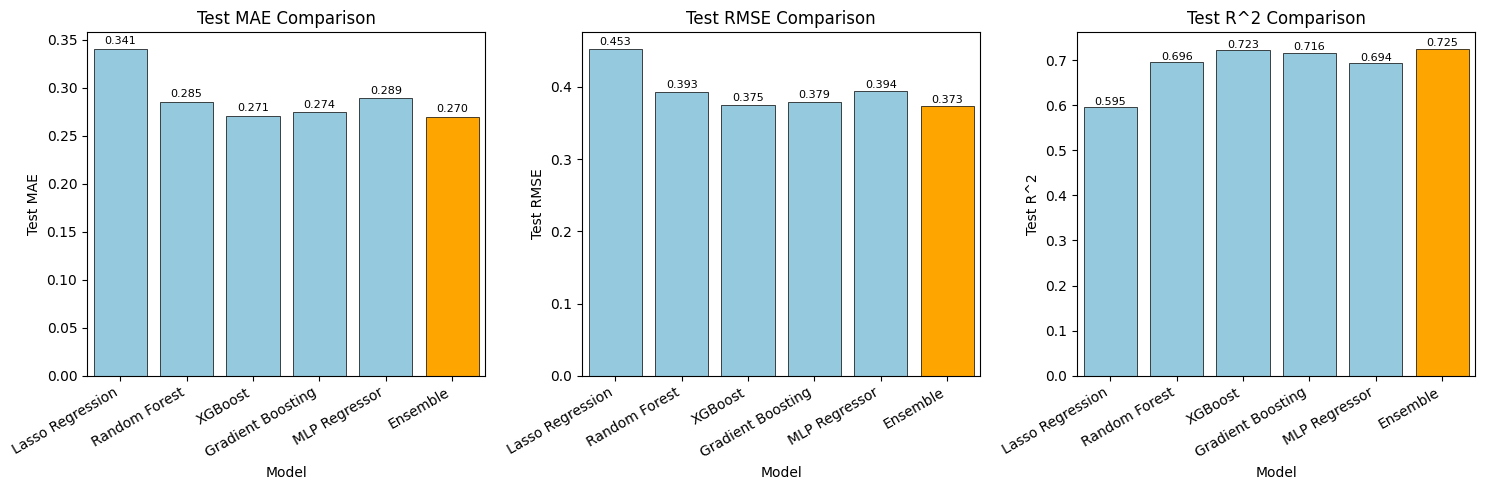

In [34]:
data = performance_df[['Model', 'Test MAE', 'Test RMSE', 'Test R^2']] 

plt.figure(figsize=(15, 5))
metrics = ["Test MAE", "Test RMSE", "Test R^2"]

for i, metric in enumerate(metrics, 1):
    plt.subplot(1, 3, i)
    bars = sns.barplot(x="Model", y=metric, data=data, color="skyblue", edgecolor='black', linewidth=0.5)
    plt.title(f"{metric} Comparison", fontsize=12)
    plt.xticks(rotation=30, ha="right", fontsize=10)
    plt.yticks(fontsize=10)
    plt.ylabel(metric, fontsize=10)
    plt.xlabel("Model", fontsize=10)

    if metric in ["Test MAE", "Test RMSE"]:
        highlight_idx = data[metric].idxmin()
    else:  # Test R^2
        highlight_idx = data[metric].idxmax()
    
    bars.patches[highlight_idx].set_facecolor("orange")
    
    for bar, value in zip(bars.patches, data[metric]):
        plt.text(
            bar.get_x() + bar.get_width() / 2, 
            bar.get_height() + 0.005, 
            f"{value:.3f}", 
            ha="center", 
            fontsize=8
        )

plt.tight_layout()

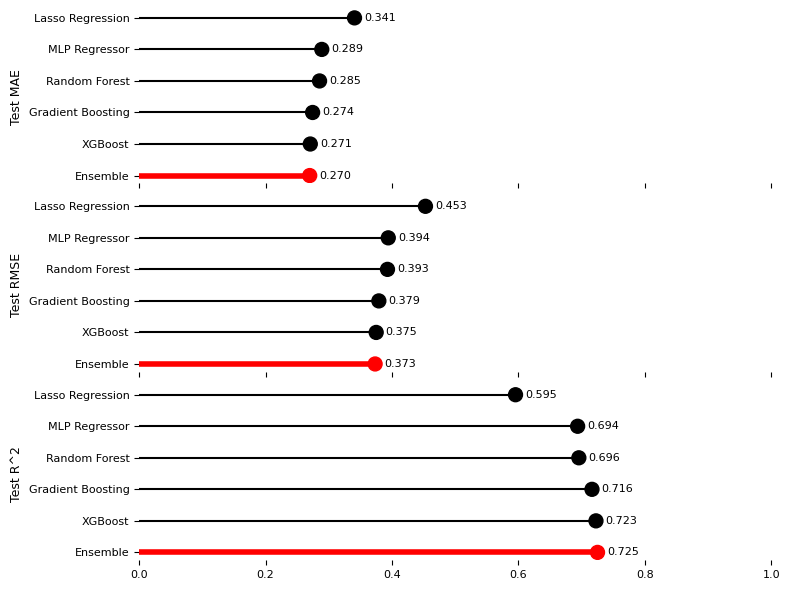

In [35]:
# Metrics to plot
metrics = ["Test MAE", "Test RMSE", "Test R^2"]

# Set up the figure
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 6), sharex=True)

# Iterate over each metric and create a lollipop chart
for i, (metric, ax) in enumerate(zip(metrics, axes)):
    data = performance_df.sort_values(by=metric, ascending=(metric != "Test R^2"))
    
    # Determine highlight condition
    highlight_idx = data[metric].idxmin() if metric in ["Test MAE", "Test RMSE"] else data[metric].idxmax()
    
    # Plot lollipop chart
    ax.hlines(y=data["Model"], xmin=0, xmax=data[metric], color="black", linewidth=1.5)
    ax.scatter(
        data[metric], 
        data["Model"], 
        color=["red" if idx == highlight_idx else "black" for idx in data.index],
        s=100
    )
    
    # Emphasize highlighted model
    ax.hlines(
        y=data.loc[highlight_idx, "Model"], 
        xmin=0, 
        xmax=data.loc[highlight_idx, metric], 
        color="red", 
        linewidth=4
    )
    
    # Add labels
    for value, model in zip(data[metric], data["Model"]):
        ax.text(value + 0.015, model, f"{value:.3f}", va="center", fontsize=8)
    
    # Configure axis and labels
    ax.set_ylabel(f"{metric}", fontsize=9)
    ax.set_xlabel("")
    ax.set_xlim(0, 1)
    
    # Remove grid lines
    ax.yaxis.grid(False)
    ax.xaxis.grid(False)
    ax.tick_params(axis='x', labelsize=8, colors='black')  
    ax.tick_params(axis='y', labelsize=8, colors='black')
    
    # Remove all borders around the plot (no box)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

plt.tight_layout()

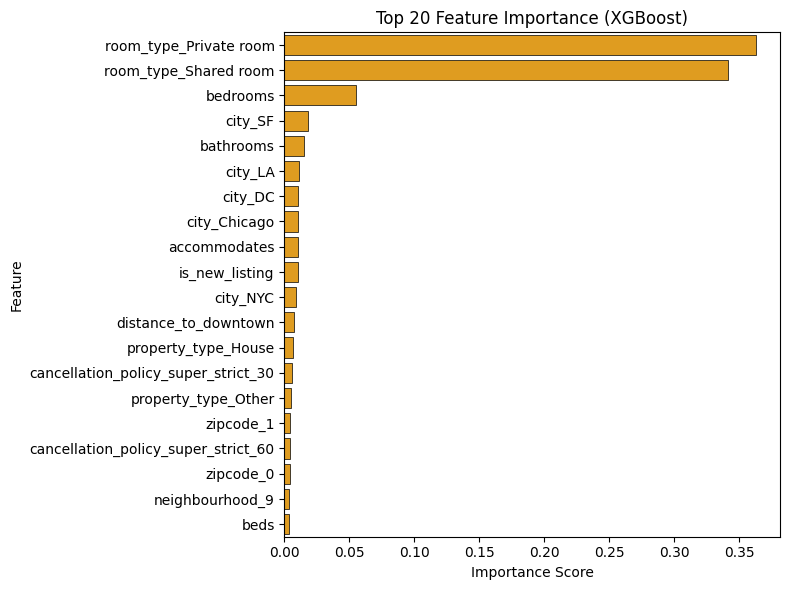

In [36]:
feature_importances = best_xgb_model.feature_importances_

importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": feature_importances
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(data=importance_df.head(20), x="Importance", y="Feature", color='orange', edgecolor='black', linewidth=0.5)
plt.title('Top 20 Feature Importance (XGBoost)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()

In [38]:
# Calculate feature importance for Random Forest, XGBoost, Gradient Boosting, and MLP
rf_importance = best_rf_model.feature_importances_
xgb_importance = best_xgb_model.feature_importances_
gbm_importance = best_gbm_model.feature_importances_

# Store the feature importances in a list or array
feature_importances = {
    'Random Forest': rf_importance,
    'XGBoost': xgb_importance,
    'Gradient Boosting': gbm_importance,
}

feature_names = X_train.columns

# Initialize an empty DataFrame
feature_importance_df = pd.DataFrame()

# Loop through the feature_importances dictionary to add each model's importances
for model_name, importances in feature_importances.items():
    # Create a temporary DataFrame for the current model
    temp_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances,
        'Model': model_name
    })
    # Append to the main DataFrame
    feature_importance_df = pd.concat([feature_importance_df, temp_df], ignore_index=True)


In [39]:
feature_importance_df

,Feature,Importance,Model
0,accommodates,0.027376,Random Forest
1,bathrooms,0.056277,Random Forest
2,host_response_rate,0.004782,Random Forest
3,neighbourhood_0,0.000069,Random Forest
4,neighbourhood_1,0.003086,Random Forest
...,...,...,...
166,instant_bookable_t,0.001280,Gradient Boosting
167,amenities_cluster_1,0.000547,Gradient Boosting
168,amenities_cluster_2,0.001019,Gradient Boosting
169,amenities_cluster_3,0.001236,Gradient Boosting


In [40]:
feature_importance_df.to_csv('data/feature_importance_df.csv')

In [41]:
# Define the prefixes to group by
group_prefixes = ['room_type', 'city', 'zipcode', 'neighbourhood', 'property_type', 'cancellation_policy', 'amenities']

description_feature_columns = [
    "important_word_ratio", 
    "selected_word_ratio", 
    "word_count", 
    "description_length", 
    "selected_word_count"
]

grouped_results = []

for prefix in group_prefixes:
    mask = feature_importance_df['Feature'].str.startswith(prefix)
    if mask.any():
        group_sum = feature_importance_df.loc[mask].groupby('Model')['Importance'].sum().reset_index()
        group_sum['Feature'] = f"{prefix}_group"
        grouped_results.append(group_sum)
        feature_importance_df = feature_importance_df[~mask]

mask_desc = feature_importance_df['Feature'].isin(description_feature_columns)
if mask_desc.any():
    desc_sum = feature_importance_df.loc[mask_desc].groupby('Model')['Importance'].sum().reset_index()
    desc_sum['Feature'] = "description_features"
    grouped_results.append(desc_sum)
    feature_importance_df = feature_importance_df[~mask_desc]

grouped_df = pd.concat(grouped_results, ignore_index=True)
grouped_importance_df = pd.concat([feature_importance_df, grouped_df], ignore_index=True).reset_index(drop=True)

# 출력
print(grouped_importance_df)


                 Feature  Importance              Model
0           accommodates    0.027376      Random Forest
1              bathrooms    0.056277      Random Forest
2     host_response_rate    0.004782      Random Forest
3      number_of_reviews    0.025240      Random Forest
4   review_scores_rating    0.011928      Random Forest
..                   ...         ...                ...
58       amenities_group    0.027730      Random Forest
59       amenities_group    0.015134            XGBoost
60  description_features    0.045801  Gradient Boosting
61  description_features    0.080552      Random Forest
62  description_features    0.012166            XGBoost

[63 rows x 3 columns]


In [42]:
grouped_importance_df

,Feature,Importance,Model
0,accommodates,0.027376,Random Forest
1,bathrooms,0.056277,Random Forest
2,host_response_rate,0.004782,Random Forest
3,number_of_reviews,0.025240,Random Forest
4,review_scores_rating,0.011928,Random Forest
...,...,...,...
58,amenities_group,0.027730,Random Forest
59,amenities_group,0.015134,XGBoost
60,description_features,0.045801,Gradient Boosting
61,description_features,0.080552,Random Forest


In [43]:
grouped_importance_df.to_csv('data/grouped_importance_df.csv')

In [44]:
# grouped_importance_df = pd.read_csv('data/grouped_importance_df.csv', index_col=0)

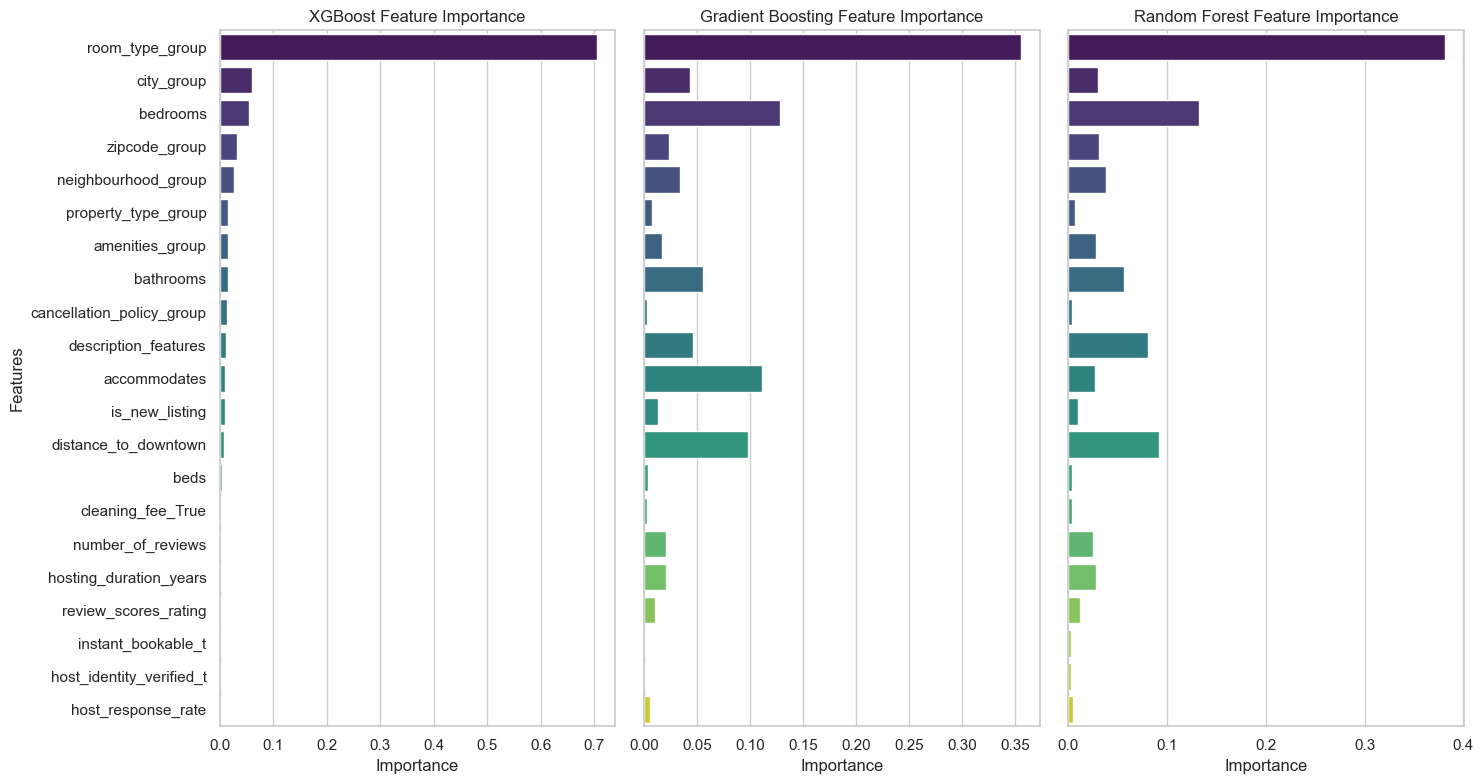

In [45]:
# Plot feature importance
xgb_sorted = grouped_importance_df[grouped_importance_df['Model'] == 'XGBoost'].sort_values('Importance', ascending=False)
sorted_features = xgb_sorted['Feature']

grouped_importance_df['Feature'] = pd.Categorical(grouped_importance_df['Feature'], categories=sorted_features, ordered=True)
grouped_importance_df = grouped_importance_df.sort_values('Feature')

models = ['XGBoost', 'Gradient Boosting', 'Random Forest']
model_data = {model: grouped_importance_df[grouped_importance_df['Model'] == model] for model in models}

sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(15, 8), sharey=True)

for ax, model in zip(axes, models):
    sns.barplot(
        y="Feature",
        x="Importance",
        data=model_data[model],
        ax=ax,
        palette="viridis"
    )
    ax.set_title(f"{model} Feature Importance")
    ax.set_xlabel("Importance")
    if model != "XGBoost":  
        ax.set_ylabel("")
        ax.tick_params(axis='y', left=False)
    else:
        ax.set_ylabel("Features")

plt.tight_layout()


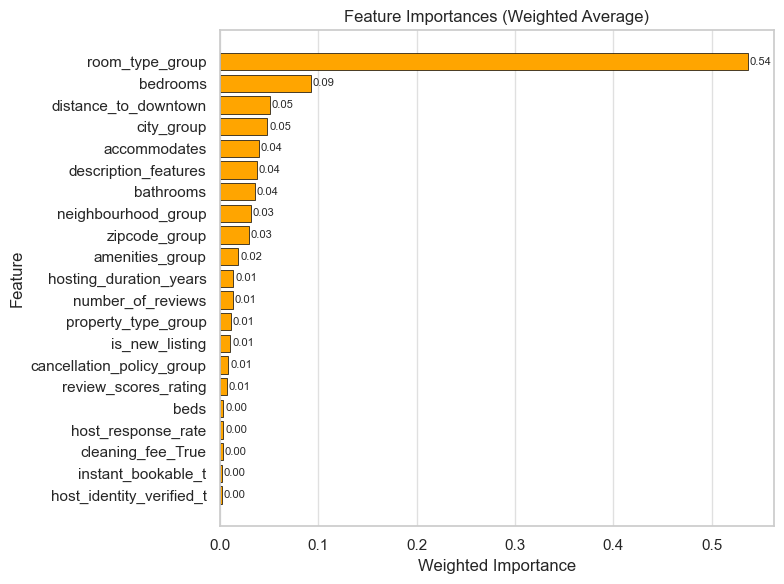

In [46]:
# Normalize the importance values by model
grouped_importance_df['Normalized_Importance'] = grouped_importance_df.groupby('Model')['Importance'].transform(lambda x: x / x.sum())

# weights for each model
weights = {'Random Forest': 0.25, 'XGBoost': 0.5, 'Gradient Boosting': 0.25}

# Calculate the weighted importance
grouped_importance_df['Weighted_Importance'] = grouped_importance_df['Normalized_Importance'] * grouped_importance_df['Model'].map(weights)

# Aggregate the weighted importance by feature
final_importance = grouped_importance_df.groupby('Feature')['Weighted_Importance'].sum().reset_index()

final_importance = final_importance.sort_values(by='Weighted_Importance', ascending=False)

plt.figure(figsize=(8, 6))
bars = plt.barh(final_importance['Feature'], final_importance['Weighted_Importance'], color='orange', edgecolor='black', linewidth=0.5)

for bar in bars:
    plt.text(bar.get_width() + 0.002, bar.get_y() + bar.get_height()/2,
             f'{bar.get_width():.2f}', va='center', fontsize=8)

plt.grid(axis='x', alpha=0.6) 
plt.gca().yaxis.grid(False) 

plt.gca().invert_yaxis() 
plt.xlabel('Weighted Importance')
plt.ylabel('Feature')
plt.title('Feature Importances (Weighted Average)')
plt.tight_layout()

In [ ]:
final_importance